# Calculating the root mean square deviation of atomic structures

We calculate the RMSD of domains in adenylate kinase as it transitions from an open to closed structure, and look at calculating weighted RMSDs.

**Last executed:** Feb 06, 2020 with MDAnalysis 0.20.2-dev0

**Last updated:** January 2020

**Minimum version of MDAnalysis:** 0.17.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests
   
**Optional packages for visualisation:**
    
* [pandas](https://pandas.pydata.org)

<div class="alert alert-info">
    
**Note**

MDAnalysis implements RMSD calculation using the fast QCP algorithm (<a data-cite="theobald_rapid_2005" href="https://doi.org/10.1107/S0108767305015266">Theobald, 2005</a>). Please cite (<a data-cite="theobald_rapid_2005" href="https://doi.org/10.1107/S0108767305015266">Theobald, 2005</a>) when using the ``MDAnalysis.analysis.align`` module in published work.

</div>

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD, CRD
from MDAnalysis.analysis import rms

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>) The trajectory ``DCD`` samples a transition from a closed to an open conformation. AdK has three domains: 

  * CORE
  * LID: an ATP-binding domain
  * NMP: an AMP-binding domain
  
The LID and NMP domains move around the stable CORE as the enzyme transitions between the opened and closed conformations. One way to quantify this movement is by calculating the root mean square deviation (RMSD) of atomic positions.

In [2]:
u = mda.Universe(PSF, DCD)  # closed AdK (PDB ID: 1AKE)
ref = mda.Universe(PSF, CRD)  # open AdK (PDB ID: 4AKE)

## RMSD between two sets of coordinates

The ``MDAnalysis.analysis.rms.rmsd`` function returns the root mean square deviation (in Angstrom) between two sets of coordinates. Here, we calculate the RMSD between the backbone atoms of the open and closed conformations of AdK. Only considering the backbone atoms is often more helpful than calculating the RMSD for all the atoms, as movement in amino acid side-chains isn't indicative of overall conformational change.

In [3]:
rms.rmsd(u.select_atoms('backbone').positions,  # coordinates to align
         ref.select_atoms('backbone').positions,  # reference coordinates
         center=True,  # subtract the center of geometry
         superposition=True)  # superimpose coordinates

6.8236868672615705

## RMSD of a trajectory with multiple selections

It is more efficient to use the ``MDAnalysis.analysis.rms.RMSD`` class to calculate the RMSD of an entire trajectory to a single reference point, than to use the the ``MDAnalysis.analysis.rms.rmsd`` function.

The ``rms.RMSD`` class first performs a rotational and translational alignment of the target trajectory to the reference universe at ``ref_frame``, using the atoms in ``select`` to determine the transformation. The RMSD of the ``select`` selection is calculated. Then, *without further alignment*, the RMSD of each group in ``groupselections`` is calculated. 

In [4]:
CORE = 'backbone and (resid 1-29 or resid 60-121 or resid 160-214)'
LID = 'backbone and resid 122-159'
NMP = 'backbone and resid 30-59'

In [5]:
R = rms.RMSD(u,  # universe to align
             u,  # reference universe or atomgroup
             select='backbone',  # group to superimpose and calculate RMSD
             groupselections=[CORE, LID, NMP],  # groups for RMSD
             ref_frame=0)  # frame index of the reference
R.run()

The data is saved in ``R.rmsd`` as an array.

In [6]:
R.rmsd.shape

(98, 6)

``R.rmsd`` has a row for each timestep. The first two columns of each row are the frame index of the time step, and the time (which is guessed in trajectory formats without timesteps). The third column is RMSD of ``select``. The last few columns are the RMSD of the groups in ``groupselections``.

### Plotting the data

We can easily plot this data using the common data analysis package [pandas](https://pandas.pydata.org).

In [7]:
import pandas as pd
# the next line is necessary to display plots in Jupyter
%matplotlib inline

We can turn the ``R.rmsd`` array into a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html#dataframe) and label each column.

In [8]:
df = pd.DataFrame(R.rmsd, 
                  columns=['Frame', 'Time (ns)', 
                           'Backbone', 'CORE', 
                           'LID', 'NMP'])

df

,Frame,Time (ns),Backbone,CORE,LID,NMP
0,0.0,0.000000,7.379926e-07,4.559829e-08,1.137940e-07,7.653031e-08
1,1.0,1.000000,4.636592e-01,4.550182e-01,4.871914e-01,4.745572e-01
2,2.0,2.000000,6.419340e-01,5.754419e-01,7.940987e-01,7.270194e-01
3,3.0,3.000000,7.743983e-01,6.739184e-01,1.010261e+00,8.795031e-01
4,4.0,4.000000,8.588600e-01,7.318859e-01,1.168398e+00,9.612986e-01
...,...,...,...,...,...,...
93,93.0,92.999992,6.817898e+00,3.504430e+00,1.143376e+01,1.029267e+01
94,94.0,93.999992,6.804211e+00,3.480681e+00,1.141134e+01,1.029879e+01
95,95.0,94.999992,6.807987e+00,3.508946e+00,1.137593e+01,1.031958e+01
96,96.0,95.999992,6.821205e+00,3.498082e+00,1.139156e+01,1.037768e+01


Text(0, 0.5, 'RMSD (Angstrom)')

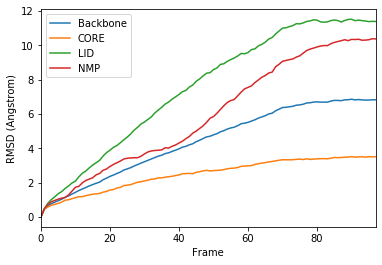

In [9]:
ax = df.plot(x='Frame', y=['Backbone', 'CORE', 'LID', 'NMP'],
             kind='line')
ax.set_ylabel('RMSD (Angstrom)')

## Weighted RMSD of a trajectory

### Mass

You can also calculate the weighted RMSD of a trajectory using a custom array of weights. (Note: up until version 0.21.0, you cannot calculate the weighted RMSD of ``groupselections``.)

In [10]:
R_mass = rms.RMSD(u, u,
                  select='protein and name CA',
                  weights='mass')
R_mass.run()

Text(0, 0.5, 'Mass-weighted RMSD (Angstrom)')

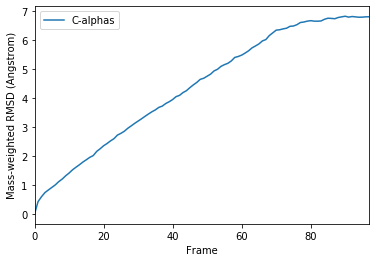

In [11]:
df_mass = pd.DataFrame(R_mass.rmsd, 
                       columns=['Frame', 
                                'Time (ns)', 
                                'C-alphas'])
ax_mass = df_mass.plot(x='Frame', y='C-alphas')
ax_mass.set_ylabel('Mass-weighted RMSD (Angstrom)')

### Charge

You can also pass in an array of values for the weights. This must have the same length as the number of atoms in ``select``.

In [12]:
ag = u.select_atoms('protein and name CA')
ag.charges.shape

(214,)

In [13]:
R_charge = rms.RMSD(u, u,
                    select='protein and name CA',
                    weights=ag.charges)
R_charge.run()

Text(0, 0.5, 'Charge-weighted RMSD (Angstrom)')

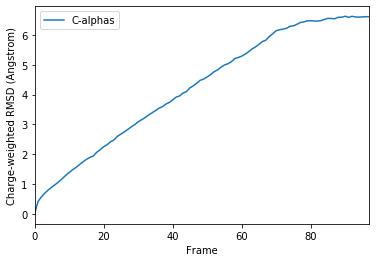

In [14]:
df_charge = pd.DataFrame(R_charge.rmsd, 
                         columns=['Frame', 
                                'Time (ns)', 
                                'C-alphas'])
ax_charge = df_charge.plot(x='Frame', y='C-alphas')
ax_charge.set_ylabel('Charge-weighted RMSD (Angstrom)')

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[4] Douglas&nbsp;L. Theobald.
Rapid calculation of <span class="bibtex-protected">RMSDs</span> using a quaternion-based characteristic polynomial.
<em>Acta Crystallographica Section A Foundations of Crystallography</em>, 61(4):478–480, July 2005.
00127.
URL: <a href="http://scripts.iucr.org/cgi-bin/paper?S0108767305015266">http://scripts.iucr.org/cgi-bin/paper?S0108767305015266</a>, <a href="https://doi.org/10.1107/S0108767305015266">doi:10.1107/S0108767305015266</a>.